In [4]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph import StateGraph, MessagesState, START, END, add_messages
from langgraph.prebuilt import ToolNode
from tavily import TavilyClient
from typing import Dict
import dotenv_loader
import os
import mlflow
from IPython.display import Image, display

In [5]:
# MLFlow setup
try:
    mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI",
                                      "http://127.0.0.1:5000"))
    mlflow.set_experiment("health_bot")
    mlflow.langchain.autolog()
except:
    print("MLflow server not running. Proceeding without MLflow.")

MLflow server not running. Proceeding without MLflow.


In [6]:
base_url = "https://openai.vocareum.com/v1"
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.2,
    base_url=base_url
)


In [7]:
class State(MessagesState):
    user_question: str
    summary: str
    comprehension_question: str
    quiz_answer: str
    quiz_choice: str
    new_topic_choice: str

In [8]:
def entry_point(state: State):
    # Starting node

    system_message = SystemMessage(
        "You are a health bot. You are a helpful and reliable assistant"
        " that answers questions about health."
        "You prefer to use web search to find information. When receiving "
        "a question, use web search to find top web search results"
        "You do not accept questions about anything else than health"
    )

    human_message = HumanMessage(state["user_question"])
    messages = add_messages(system_message, human_message)

    return {"messages": messages}

In [9]:
def agent(state: State):
    # Research agent

    ai_message = llm.invoke(state["messages"])
    return {"messages": [ai_message]}

In [10]:
def route_to_tool(state: State):
    # Routes to web search tool

    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "web_search"
    else:
        return END

In [11]:
@tool
def web_search(query: str) -> Dict:
    """
     Return top web search results for a given search query
     """

    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    response = tavily_client.search(query)
    return response

In [12]:
def summarize(state: State):
    # Summarize web search

    system_message = SystemMessage(
        "Summarize the search results from the web search tool into a "
        "coherent,"
        "helpful response, spanning 3-4 paragraphs."
        "Cite your sources."
    )
    ai_message = llm.invoke(state["messages"] + [system_message])
    return {"messages": [ai_message], "summary": ai_message.content}

In [13]:
def ask_for_quiz(state: State):
    # This is a breakpoint to ask the user for input. Doesn't do anything else.

    return state

In [14]:
def route_to_quiz(state: State):
    # Checks the user's decision from the state and routes accordingly.

    if state.get("quiz_choice") == "yes":
        return "generate_quiz"
    else:
        # If they said no, ask if they want a new topic
        return "ask_for_new_topic"

In [15]:
def ask_for_new_topic(state: State):
    # This is a breakpoint to ask the user for input. Doesn't do anything else.

    return state

In [16]:
def generate_quiz(state: State):
    system_message = SystemMessage(
        "Generate a comprehension quiz based on the summary from the web "
        "search tool."
        "Only generate one single-sentence question and no options for "
        "answers, as the user is supposed to provide a free text answer."
        "Do not generate the correct answer yet."
        f'Use only this information as source for your question: '
        f'{state["summary"]}'
    )
    ai_message = llm.invoke(state["messages"] + [system_message])

    return {"messages": [ai_message],
            "comprehension_question": ai_message.content}

In [17]:
def grade_quiz(state: State):
    system_message = SystemMessage(
        "You are grading a comprehension quiz about health"
        "Don't grade too hard - accept short answers from the user"
        f"The question was: {state['comprehension_question']}"
        f"The user's answer is: {state['quiz_answer']}"
        "Grade the user's answer with a grade from A (best) to F (failed)"
        f"For your grade, use only information from this summary of web "
        f"search results on the topic:{state['summary']}"
        "Provide a short explanation for your grade, and a citation from the "
        "summaries provided above"
    )

    # Don't need the full message history here as we're only grading
    ai_message = llm.invoke([system_message])

    return {"messages": [ai_message]}

In [18]:
# bind tools
llm = llm.bind_tools([web_search])

# build graph
workflow = StateGraph(State)
workflow.add_node("entry_point", entry_point)
workflow.add_node("agent", agent)
workflow.add_node("web_search", ToolNode([web_search]))
workflow.add_node("summarize", summarize)
workflow.add_node("generate_quiz", generate_quiz)
workflow.add_node("grade_quiz", grade_quiz)
workflow.add_node("ask_for_quiz", ask_for_quiz)
workflow.add_node("ask_for_new_topic", ask_for_new_topic)

# Start
workflow.add_edge(START, "entry_point")
workflow.add_edge("entry_point", "agent")

# Routes to web search tool
workflow.add_conditional_edges(
    source="agent",
    path=route_to_tool,
    path_map=["web_search", END]
)

workflow.add_edge("web_search", "summarize")

# At this point, we interrupt and ask if they want a quiz
workflow.add_edge("summarize", "ask_for_quiz")

# Check if they wanted a quiz and route
workflow.add_conditional_edges(
    source="ask_for_quiz",
    path=route_to_quiz,
    path_map={
        "generate_quiz": "generate_quiz",
        "ask_for_new_topic": "ask_for_new_topic"
    }
)

workflow.add_edge("generate_quiz", "grade_quiz")

# At this point, we interrupt and ask if they want a new topic
workflow.add_edge("grade_quiz", "ask_for_new_topic")
workflow.add_edge("ask_for_new_topic", END)

In [19]:
memory = MemorySaver()
graph = workflow.compile(
    interrupt_before=["ask_for_quiz", "ask_for_new_topic", "grade_quiz"],
    checkpointer=memory)

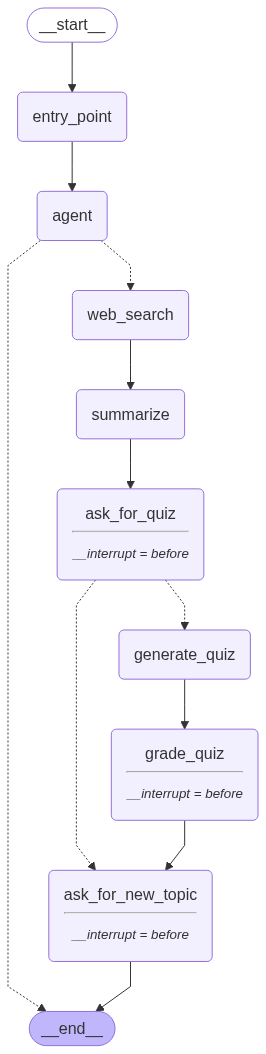

In [20]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [21]:
def hitl_health_bot(graph: CompiledStateGraph):
    # We'll start a new thread for each run of the graph
    thread_id = 0

    # Outer loop, each run is one separate conversation
    while True:

        thread_id += 1
        print(f"\n--- Starting new session (session ID: {thread_id}) ---\n")

        # Get a topic from the user and make sure they've entered something
        user_question = input("What topic would you like to learn about?\n"
                              "> ")
        if not user_question.strip():
            print("OK, see you later then!")
            break

        # Not a must but for keeping types consistent
        config = RunnableConfig()
        config["configurable"] = {"thread_id": thread_id}

        # Need to keep track of printed messages to avoid duplicates
        last_printed_message_id = None

        # This holds the input for the graph
        current_input = {"user_question": user_question}

        # This is the inner loop, representing one run of the graph
        # Basically, this keeps calling graph.stream and handles interrupts
        while True:
            for event in graph.stream(input=current_input,
                                      config=config,
                                      stream_mode="values"):
                if messages := event.get("messages", []):
                    message = messages[-1]

                    # Print the message only if it hasn't been yet
                    if (message.id != last_printed_message_id and
                            # Only print AI messages
                            message.type == "ai" and
                            message.content):
                        message.pretty_print()
                        last_printed_message_id = message.id

            # As soon as an interrupt happens, check which node is next
            state = graph.get_state(config)
            next_node = state.next[0] if state.next else None

            # Check if we've reached the end
            if not state.next or state.next[0] == END:
                # print("\n--- See you later! ---\n")
                break

            # Ask if the user wants a quiz
            if next_node == "ask_for_quiz":
                # Start the quiz loop if the user wants to
                quiz_requested = input("\nWould you like to do a quiz? (y/n)\n"
                                       "> ")
                choice = "yes" if (quiz_requested.lower().strip()
                                   in ["y", "yes"]) else "no"

                # Update the graph state so the router knows what to do
                graph.update_state(config, {"quiz_choice": choice})

            # Capture the answer to the quiz
            elif next_node == "grade_quiz":
                # Get the user's answer and make sure it's long enough
                quiz_answer = input("Please state your answer:\n"
                                    "> ")
                while not quiz_answer.strip() or len(quiz_answer) < 5:
                    quiz_answer = input(
                        "It looks like you haven't entered an answer. Please "
                        "try again.\n"
                        "> ")

                graph.update_state(config, {"quiz_answer": quiz_answer})

            # Ask the user if they want a new topic
            elif next_node == "ask_for_new_topic":
                new_topic_choice = input("\nResearch another topic? (y/n)\n> ")
                choice = "yes" if new_topic_choice.lower().strip() in [
                    "y", "yes"] else "no"
                graph.update_state(config, {"new_topic_choice": choice})

            # After this, the inner loop will run again and continue the stream
            # Hence we need to make sure the graph's input will be empty
            current_input = None

        # If the user answered they don't want a new topic, we'll end the
        # outer loop and the program stops
        final_state = graph.get_state(config)
        if final_state.values.get("new_topic_choice") == "no":
            print("Got it, goodbye!")
            break

In [ ]:
 # Run the loop
 hitl_health_bot(graph=graph)


--- Starting new session (session ID: 1) ---



What topic would you like to learn about?
>  hmm don't really know... 


================================== Ai Message ==================================

It seems like you might have a question about health. Please feel free to ask, and I'll do my best to assist you!

--- Starting new session (session ID: 2) ---



What topic would you like to learn about?
>  i think cats are really cool! 


================================== Ai Message ==================================

I'm here to help with health-related questions. If you have any inquiries about health, feel free to ask!

--- Starting new session (session ID: 3) ---



What topic would you like to learn about?
>  ok, how about back pain then? 


================================== Ai Message ==================================

Back pain is a prevalent issue that affects many individuals, often leading them to seek medical attention or take time off work. It can arise from various causes, including strains, spine disorders, or conditions affecting organs in the pelvis or abdomen. Common symptoms of back pain may include discomfort in the lower back, stiffness, and sometimes radiating pain to other areas. Factors such as age, physical activity level, and underlying health conditions can influence the likelihood of experiencing back pain (Cleveland Clinic).

The treatment for back pain typically involves a combination of medications, physical therapy, and lifestyle modifications. Over-the-counter pain relievers, such as ibuprofen or acetaminophen, are often recommended for mild to moderate pain. In more severe cases, healthcare providers may prescribe stronger medications or suggest therapies like chiropractic care, acupuncture, o


Would you like to do a quiz? (y/n)
>  y


================================== Ai Message ==================================

What are some common causes and symptoms of back pain?


Please state your answer:
>  bad posture and being too fat. and symptoms, well - having pain? 
